<a href="https://colab.research.google.com/github/guscldns/TestProject/blob/main/0724/05_2_(solution)yolov1_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# yolov1_implementation

출처 : https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/object_detection/YOLO

1. architecture
2. IOU
3. loss

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter

## Architecture

In [ ]:
# architecture_config = [
#     (7, 64, 2, 3),
#     "M",
#     (3, 192, 1, 1),
#     "M",
#     (1, 128, 1, 0),
#     (3, 256, 1, 1),
#     (1, 256, 1, 0),
#     (3, 512, 1, 1),
#     "M",
#     [(1, 256, 1, 0), (3, 512, 1, 1), 4],
#     (1, 512, 1, 0),
#     (3, 1024, 1, 1),
#     "M",
#     [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
#     (3, 1024, 1, 1),
#     (3, 1024, 2, 1),
#     (3, 1024, 1, 1),
#     (3, 1024, 1, 1),
# ]

In [ ]:
def yolo_v1(input_shape, num_classes, num_boxes):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # First
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.1))(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)

    # Second
    x = tf.keras.layers.Conv2D(filters=192, kernel_size=3, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)

    # Third
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=1, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=1, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)

    # Fourth
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=1, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=1, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=1, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=1, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=1, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)

    # Fifth
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=1, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=1, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, strides=2, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)

    # Sixth
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=3, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)

    # F.C
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(4096, activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)
    outputs = tf.keras.layers.Dense(7*7*30, activation='linear')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

## IOU

#### tensorflow method 정리
- tf.math.maximum(a, b) : a, b 중 큰 값 리턴
- tf.math.minimum(a, b) : a, b 중 작은 값 리턴
- tf.math.abs(a) : a 절대값 리턴

In [ ]:
def iou(boxes_1, boxes_2, box_format="midpoint"):
    """
        박스 두개 입력받아서 두 박스의 iou 계산하여 return
    """
    # 1. calculate preds box xmin, ymin, xmax, ymax
    box1_x1 = boxes_1[..., 0:1] - boxes_1[..., 2:3] / 2
    box1_y1 = boxes_1[..., 1:2] - boxes_1[..., 3:4] / 2
    box1_x2 = boxes_1[..., 0:1] + boxes_1[..., 2:3] / 2
    box1_y2 = boxes_1[..., 1:2] + boxes_1[..., 3:4] / 2

    # 2. calculate labels box xmin, ymin, xmax, ymax
    box2_x1 = boxes_2[..., 0:1] - boxes_2[..., 2:3] / 2
    box2_y1 = boxes_2[..., 1:2] - boxes_2[..., 3:4] / 2
    box2_x2 = boxes_2[..., 0:1] + boxes_2[..., 2:3] / 2
    box2_y2 = boxes_2[..., 1:2] + boxes_2[..., 3:4] / 2

    # 3. calculate intersection area
    ## 3-1) inter-box xmin, ymin, xmax, ymax
    x1 = tf.math.maximum(box1_x1, box2_x1)
    y1 = tf.math.maximum(box1_y1, box2_y1)
    x2 = tf.math.minimum(box1_x2, box2_x2)
    y2 = tf.math.minimum(box1_y2, box2_y2)

    ## 3-2) set 0 for the case when they do not intersect
    intersection = tf.math.maximum(x2 - x1, 0) * tf.math.maximum(y2 - y1, 0)

    ## 3-3) calculate area
    box1_area = tf.math.abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = tf.math.abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    # 4. calculate IOU
    i_o_u = intersection / (box1_area + box2_area - intersection + 1e-6)
    return i_o_u


def nms(bboxes, iou_threshold, threshold):
    """
    Parameters:
        bboxes (list): bbox 정보 [predicted_class, confidence, x1, y1, x2, y2] 묶음(list)
        iou_threshold (float): NMS를 위한 iou threshold
        threshold (float): confidence가 낮은 bbox를 탈락시키기 위한 threshold
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: NMS를 수행하고 남은 bboxes
    """
    ############################################################################
    bboxes = [box for box in bboxes if box[1] > threshold] # bboxes 중에서 confidence가 낮은 bbox 제외
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True) # confidence 순으로 내림차순 정렬
    bboxes_nms = [] # return할 bbox 리스트

    # nms 수행하여 bboxes_nms 리스트 생성
    while bboxes:
        chosen_box = bboxes.pop(0) # bboxes에서 confidence 최고값인 box 정보 선택

        # bboxes 재정의 : chosen_box 제외, chosen_box와 겹치는 box들 제외
        bboxes = [
            box for box in bboxes
            if box[0] != chosen_box[0] or iou(chosen_box[2:], box[2:]) < iou_threshold
        ]

        bboxes_nms.append(chosen_box)
    ############################################################################
    return bboxes_nms

## Loss

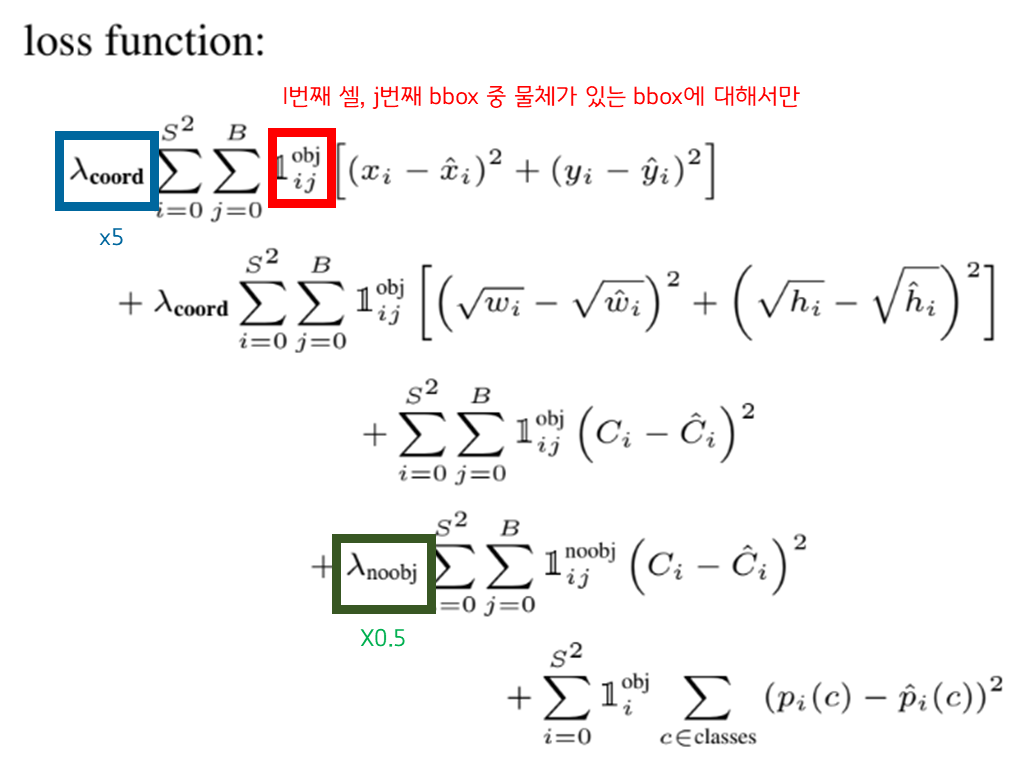

#### tensorflow method 정리
- tf.reshape(대상, shape) : 대상을 shape으로 reshape
- tf.concat([a, b], axis) : a, b를 axis 기준으로 병합
- tf.expand_dims(대상, axis) : 대상을 axis 기준으로 차원 추가  
  
  

```
예) 아래처럼 변형하고 싶다면?  
  [[1, 2, 3], [4, 5, 6]] : shape=(2, 3) -> [[[1, 2, 3], [4, 5, 6]]] : shape=(1, 2, 3)

  tf.expand_dims(대상, axis=0)
```

- tf.where(조건, a, b) : 조건이 참이면 a 리턴, 거짓이면 b 리턴
- tf.equal(a, b) : 둘이 같으면 참, 아니면 거짓 리턴
- tf.reduce_sum(대상, axis) : 대상을 axis기준으로 sum 계산 리턴


In [ ]:
def loss(predictions, target):
    S = 7
    B = 2
    C = 20
    lambda_noobj = 0.5
    lambda_coord = 5

    predictions = tf.reshape(predictions, [-1, S, S, C + B * 5])
    ## predictions shape : -1x7x7x30
    ## 채널 30(0~29) 설명 : (주의) 채널의 순서가 수업자료와 상이함.
        # 0~19 -> class prediction
        # 20, 25 -> confidence
        # 21~24, 26~29 -> bbox coord

    iou_b1 = iou(predictions[..., 21:25], target[..., 21:25])
    iou_b2 = iou(predictions[..., 26:30], target[..., 21:25])
    ious = tf.concat([tf.expand_dims(iou_b1, 0), tf.expand_dims(iou_b2, 0)], axis=0)

    # 각 그리드 별로 큰 IOU 값 추출
    iou_maxes = tf.math.reduce_max(ious, axis=0)

    # 그에 해당하는 bestbox indices 저장 (0:first bbox, 1:second bbox)
    bestbox = tf.math.argmax(ious, axis=0)

    # target matrix의 confidence -> 물체유무 값(0, 1)
    exists_box = tf.expand_dims(target[..., 20], axis=-1)

    ############################################################################
    # Box LOSS (답 제공)
    box_predictions = exists_box * (
        bestbox * predictions[..., 26:30] +
        (1 - bestbox) * predictions[..., 21:25]
    )
    box_targets = exists_box * target[..., 21:25]

    ## width & height - sqrt 적용
    box_predictions[..., 2:4] = tf.sqrt(box_predictions[..., 2:4])
    box_targets[..., 2:4] = tf.sqrt(box_targets[..., 2:4])

    box_loss = tf.reduce_sum(tf.square(box_predictions - box_targets))

    ############################################################################
    # (여기부터 작성해보세요)
    ############################################################################
    # OBJECT LOSS
    pred_box = (
        bestbox * predictions[..., 25:26] +
        (1 - bestbox) * predictions[..., 20:21]
    )

    confidence_target = exists_box * iou_maxes
    object_loss = tf.reduce_sum(tf.square(exists_box * (pred_box - confidence_target)))

    # NO-OBJECT LOSS
    no_object_loss = tf.reduce_sum(tf.square((1 - exists_box) * predictions[..., 20:21]))
    no_object_loss += tf.reduce_sum(tf.square((1 - exists_box) * predictions[..., 25:26]))

    # CLASS LOSS
    class_loss = tf.reduce_sum(tf.square(exists_box * predictions[..., :20] - target[..., :20]))


    # TOTAL LOSS
    loss = (
        lambda_coord * box_loss +
        object_loss +
        lambda_noobj * no_object_loss +
        class_loss
    )
    ############################################################################
    return loss
